# Match DMRs to featureCounts matrix

In [2]:
# import DMR dataframes from txt file 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

# 1 Import data 

In [3]:
# read in DMR data (unique gene ids) 
with open('7_match_dmr_to_gene/dmr_within_geneborders_genelist/dmr_unique_geneids.json', 'r') as f:
    dmr_unique_geneids = json.load(f)
# concaternte all DMRs into one list 
dmr = [item for sublist in dmr_unique_geneids.values() for item in sublist]

In [4]:
# import fetaure cpounts (gene expression data)
expression = pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/RNAseq_pipeline/9_create_GeneCountsMatrix/gene_matrix_count.csv', sep=',', index_col=0)

# 2 Import Protein Names

In [5]:
names = pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/DNAseq_pipeline/13_protein_sequence/blastp_hits_swissprot_genes.txt', sep='\t', index_col=0)

In [6]:
names['symbol'] = names['symbol'].str.split('_').str[0]

# 2 Filter expression data to only contain DMR genes
Filter out low counts (below 50 as sum) 

In [7]:
# filter expression df for all the DMR genes
expressiondmr = expression[expression.index.isin(dmr)]
# filter the rows that have as a sum less than 50 counts
expressiondmr = expressiondmr[(expressiondmr.sum(axis=1) >= 50)]
# Specify the desired column order
column_order = ['N1', 'N2', 'N3', 'N7', 'A1', 'A2', 'A4', 'A7', 'R2', 'R3', 'R7', 'R8']
# Reorder the dataframe columns
expressiondmr = expressiondmr.reindex(columns=column_order)

In [8]:
    # create color code: 
colors={}
# all in NvsA 
colors.update({g: '#DE8F05' for g in dmr_unique_geneids['NvsA']})
# all in NvsR minus intersection with NvsA
colors.update({g: '#029E73' for g in set(dmr_unique_geneids['NvsR']) - (set(dmr_unique_geneids['NvsR']).intersection(dmr_unique_geneids['NvsA']))})
# all in AvsR minus intersection with NvsA
colors.update({g: '#0173B2' for g in set(dmr_unique_geneids['AvsR']) - (set(dmr_unique_geneids['AvsR']).intersection(dmr_unique_geneids['NvsA']))})

colors = pd.Series(colors, name='condition')

In [9]:
dmrna=[]
dmrnr=[]
dmrar=[]

# split the expressiondmr df into three df 
expressionNA = expressiondmr[expressiondmr.index.isin(dmr_unique_geneids['NvsA'])]
expressionNR = expressiondmr[expressiondmr.index.isin(dmr_unique_geneids['NvsR'])]
expressionAR = expressiondmr[expressiondmr.index.isin(dmr_unique_geneids['AvsR'])]

In [10]:
def convert_gene_to_protein_names(gene_names):
    return names['symbol'].get(gene_names, default='unknown')


In [11]:
protein_label = expressiondmr.index.map(convert_gene_to_protein_names)


# 4 Plot DMR heatmap 

In [12]:
sns.color_palette("Set2")[4]

(0.6509803921568628, 0.8470588235294118, 0.32941176470588235)

In [13]:
# Setup the sample sex information
sex_info = {
    'N1': 'M',
    'N2': 'F',
    'N3': 'M',
    'N7': 'M',
    'A1': 'M',
    'A2': 'M',
    'A4': 'M',
    'A7': 'M',
    'R2': 'F',
    'R3': 'F',
    'R7': 'F',
    'R8': 'F'
    # Add all sample mappings
}

# Define colors
sex_colors = {
    'M': 'black',   # Color for males
    'F': sns.color_palette("hls", 8)[0]    # Color for females
}

/tmp/ipykernel_9762/2174905364.py:34: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


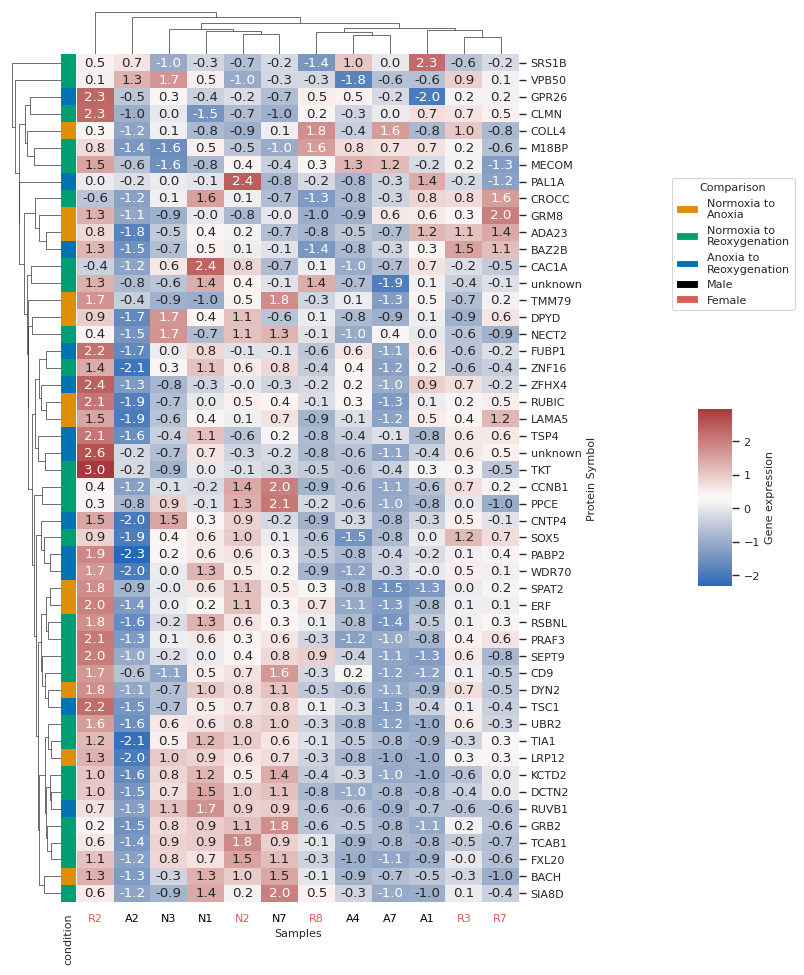

In [13]:
from matplotlib.patches import Patch

sns.set_theme(style = 'whitegrid', context='paper', rc={'axes.labelsize':8, 'xtick.labelsize':8, 'ytick.labelsize':8, 'legend.fontsize':8, 'legend.title_fontsize':8})
g = sns.clustermap(expressiondmr, 
                cmap='vlag', figsize=(17/2.54, 25/2.54), cbar_pos=(1.05, 0.4, 0.05, 0.18), 
                cbar_kws={'label': 'Gene expression'}, xticklabels=True, yticklabels=True, 
                annot=True, fmt=".1f", col_cluster=True, z_score=0, row_cluster=True, dendrogram_ratio=(0.1, 0.05), row_colors=colors)
#g.figure.suptitle('DMR expression')
g.ax_heatmap.set_xlabel('Samples')
# Customization of xtick labels based on sex_info with colors
xtick_labels = [label.get_text() for label in g.ax_heatmap.get_xticklabels()]
# Apply color to the xtick labels based on sex information
for label in g.ax_heatmap.get_xticklabels():
    sample_name = label.get_text()
    sex = sex_info.get(sample_name, '')
    label.set_color(sex_colors.get(sex, 'black'))
# Legend for the heatmap including sex information
legend_elements = [
    Patch(facecolor='#DE8F05', label='Normoxia to\nAnoxia'),
    Patch(facecolor='#029E73', label='Normoxia to\nReoxygenation'),
    Patch(facecolor='#0173B2', label='Anoxia to\nReoxygenation'),
    Patch(facecolor='black', label='Male'),
    Patch(facecolor=sns.color_palette("hls", 8)[0], label='Female')
]


# convert gene id names to protein names
y_ticks = [label.get_text() for label in g.ax_heatmap.get_yticklabels()]
g.ax_heatmap.set_yticklabels(list(map(convert_gene_to_protein_names, y_ticks)))
g.ax_heatmap.set_ylabel('Protein Symbol')
# Adding the legend
g.ax_cbar.legend(loc='upper left', bbox_to_anchor=(-0.8, 2.3), title='Comparison', handles=legend_elements, borderaxespad=0.)
# Adjust layout
plt.tight_layout()
# export as png 
g.savefig('8_DMR_gene_expression/dmr_expression_heatmap.svg')
g.savefig('8_DMR_gene_expression/dmr_expression_heatmap.png', dpi=300)
